In [1]:
%load_ext autoreload
%matplotlib inline

%autoreload 2

from glob import glob
from dask.delayed import delayed
import dask.dataframe as dd
import pandas as pd
import numpy as np
from functools import reduce
from tqdm import tqdm
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud

import matplotlib.pylab as plt
plt.style.use('ggplot')

from utils import read_ngrams, save_ngrams

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

In [3]:
ARTICLES = [
    "article one",
    "article two",
    "article three",
    "article four",
    "article five",
    "article six",
    "article seven"
]

AMENDMENTS = [
    "first amendment",
    "second amendment",
    "third amendment",
    "fourth amendment",
    "fifth amendment",
    "sixth amendment",
    "seventh amendment",
    "eighth amendment",
    "ninth amendment",
    "tenth amendment",
    "eleventh amendment",
    "twelfth amendment",
    "thirteenth amendment",
    "fourteenth amendment",
    "fifteenth amendment",
    "sixteenth amendment",
    "seventeenth amendment",
    "eighteenth amendment",
    "nineteenth amendment",
    "twentieth amendment",
    "twenty-first amendment",
    "twenty-second amendment",
    "twenty-third amendment",
    "twenty-fourth amendment",
    "twenty-fifth amendment",
    "twenty-sixth amendment",
    "twenty-seventh amendment"
]

QUERIES = ARTICLES + AMENDMENTS

In [4]:
df_raw = read_ngrams("/mnt/volume_sfo2_03/downloads/google_ngrams/5/constitution-parsed-gz/part-*")
df_raw.columns = ['query', 'r1', 'r2', 'r3', 'year', 'total', 'distinct']
df_raw = df_raw.compute()

In [5]:
df = (pd.concat([
    df_raw[['query', w, 'year', 'total', 'distinct']].rename(columns={w: 'w'})
    for w in ['r1', 'r2', 'r3']
]).groupby(['w', 'query', 'year'])
      .sum()
      .reset_index())

df = df[(df['year'] >= 1788) & ~ df['w'].isin(STOP_WORDS) & df['w'].str.isalnum()]
df['decade'] = df['year'] // 10 * 10

df.sample(10, random_state=42)

,w,query,year,total,distinct,decade
295096,predates,sixth amendment,1991,5,5,1990
376876,supreme,fourth amendment,1992,7,7,1990
189725,gives,sixth amendment,2006,3,3,2000
267645,observance,fourteenth amendment,1978,1,1,1970
379411,taxpayers,fifth amendment,2005,8,8,2000
278584,ordinance,first amendment,2005,28,25,2000
293727,power,thirteenth amendment,1902,2,2,1900
173240,federal,fifteenth amendment,1911,24,19,1910
323455,reach,fifteenth amendment,1991,1,1,1990
336144,require,fourteenth amendment,1970,14,13,1970


In [6]:
def pad(x, n):
    return np.pad(x, (0, n-len(x)), 'constant', constant_values=(np.nan, np.nan))

def highest_table(df, n, by, df_denominator=None, bayesian_smoothing=10):
    """ baseline is either None of a dataframe.  If None, df is used """
    if df_denominator is None:
        df_ratios = (df.groupby(['w', by])[['total', 'distinct']].sum() / (df.groupby(['w'])[['total', 'distinct']].sum() + bayesian_smoothing)).reset_index()
    else:
        df_ratios = (df.groupby(['w', by])[['total', 'distinct']].sum() / (df_denominator.groupby(['w'])[['total', 'distinct']].sum() + bayesian_smoothing)).reset_index()
    
    return pd.DataFrame({
        q: pad(x.nlargest(n, 'total')['w'].values, n)
        for q, x in df_ratios.sort_values([by, 'total'], ascending=False).groupby(by)
    }).fillna("").T

display(highest_table(df, 8, 'query').reindex([q for q in QUERIES if not q.startswith("twenty-")]))


,0,1,2,3,4,5,6,7
article one,tribunal,chapter,follows,fully,8,authorize,mentioned,section
article two,roadmap,warranties,uniform,project,ucc,steam,strokes,73
article three,geneva,times,treaty,section,read,act,provisions,constitution
article four,underwrite,manner,lights,leave,prescribed,chapter,treaty,provided
article five,treaty,chapter,provisions,federal,constitution,,,
article six,soviet,charter,treaty,provisions,constitution,,,
article seven,seven,fourteen,submit,publication,days,treaty,proposed,section
first amendment,religion,establishment,center,alleged,forum,regulation,speech,erected
second amendment,embarrassing,fund,imf,terrifying,constituted,academics,explorations,twentieth
third amendment,1961,quartering,arms,senate,bear,act,association,prohibition


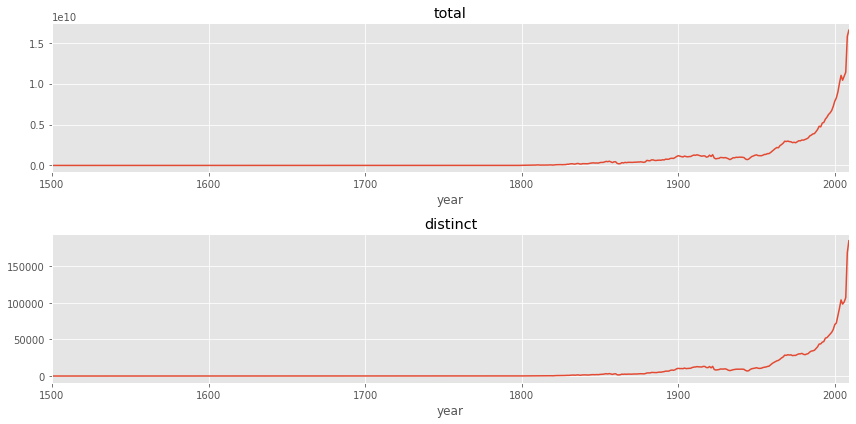

In [7]:
df_baseline = pd.read_csv("/mnt/volume_sfo2_02/googlebooks-eng-us-all-totalcounts-20120701.txt",
                          lineterminator='\t',
                          names=['year', 'total', 'page', 'distinct']).set_index('year')
_, axes = plt.subplots(nrows=2, ncols=1)
df_baseline['total'].plot(ax=axes[0], title='total')
df_baseline['distinct'].plot(ax=axes[1], title='distinct')
plt.tight_layout()


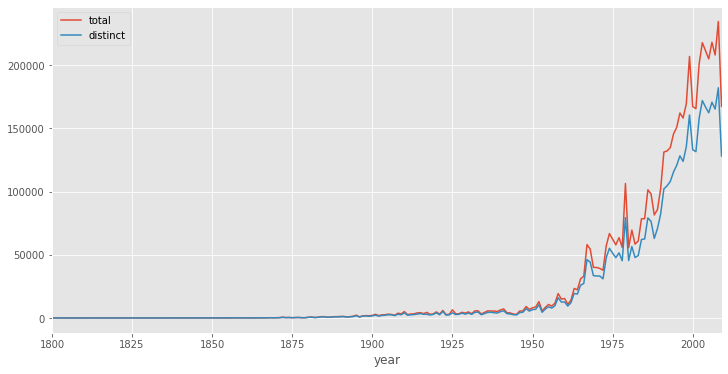

In [8]:
df.groupby(['year'])[['total', 'distinct']].sum().plot();

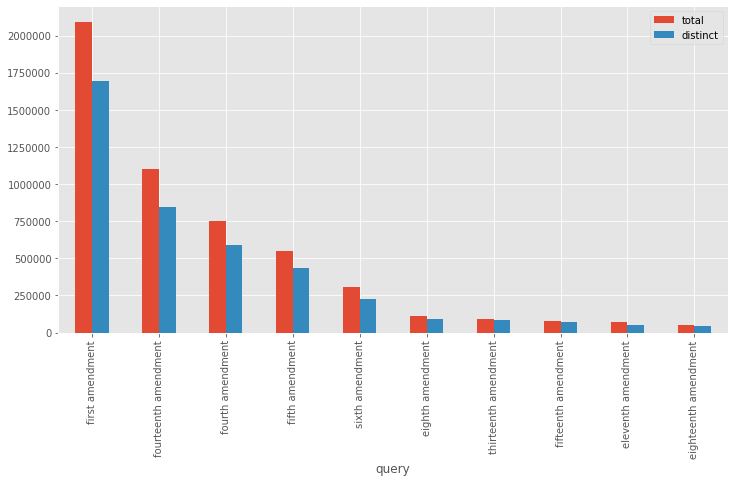

In [9]:
df_queries = (df.groupby(['query'])[['total', 'distinct']]
     .sum()
     .sort_values('total', ascending=False))

(df_queries.nlargest(10, 'total')
     .plot.bar());

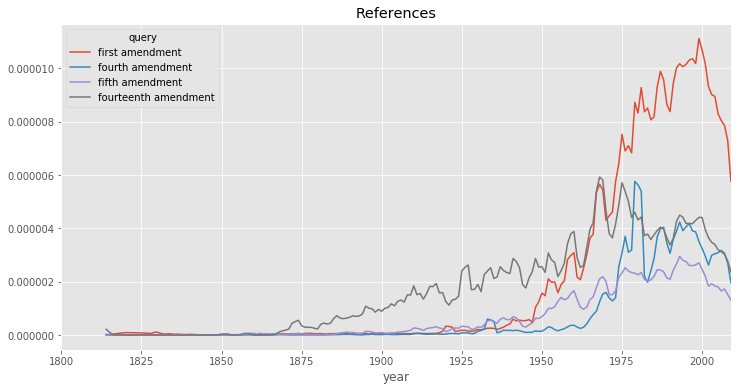

In [10]:
top_n = df_queries.nlargest(4, 'total').index

df_query_year = (
    df.groupby(['query', 'year'])[['total', 'distinct']].sum() /
    (df_baseline)
)

(df_query_year.loc[top_n, :]
     .unstack('query')['total']
     .reindex([q for q in QUERIES if q in top_n], axis=1)
     .fillna(0)
     .sort_index()
     .rolling(3)
     .mean()
     .plot(title="References"))

# Similar to https://books.google.com/ngrams/graph?content=first+amendment%2Cfourteenth+amendment%2Cfourth+amendment%2Cfifth+amendment&case_insensitive=on&year_start=1800&year_end=2008&corpus=17&smoothing=2&share=&direct_url=t4%3B%2Cfirst%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFirst%20Amendment%3B%2Cc0%3B%3Bfirst%20amendment%3B%2Cc0%3B%3Bfirst%20Amendment%3B%2Cc0%3B.t4%3B%2Cfourteenth%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFourteenth%20Amendment%3B%2Cc0%3B%3Bfourteenth%20amendment%3B%2Cc0%3B.t4%3B%2Cfourth%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFourth%20Amendment%3B%2Cc0%3B%3Bfourth%20amendment%3B%2Cc0%3B%3Bfourth%20Amendment%3B%2Cc0%3B.t4%3B%2Cfifth%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFifth%20Amendment%3B%2Cc0%3B%3Bfifth%20amendment%3B%2Cc0%3B%3Bfifth%20Amendment%3B%2Cc0#t4%3B%2Cfirst%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFirst%20Amendment%3B%2Cc0%3B%3Bfirst%20amendment%3B%2Cc0%3B%3Bfirst%20Amendment%3B%2Cc0%3B.t4%3B%2Cfourteenth%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFourteenth%20Amendment%3B%2Cc0%3B%3Bfourteenth%20amendment%3B%2Cc0%3B.t4%3B%2Cfourth%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFourth%20Amendment%3B%2Cc0%3B%3Bfourth%20amendment%3B%2Cc0%3B%3Bfourth%20Amendment%3B%2Cc0%3B.t4%3B%2Cfifth%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFifth%20Amendment%3B%2Cc0%3B%3Bfifth%20amendment%3B%2Cc0%3B%3Bfifth%20Amendment%3B%2Cc0


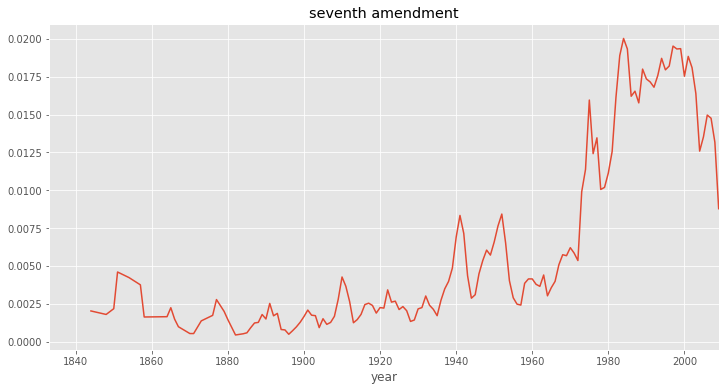

In [11]:
query = AMENDMENTS[7 - 1]

display(df_query_year.loc[query, 'distinct']
     .fillna(0)
     .sort_index()
     .rolling(3)
     .mean()
     .plot(title=query))

In [12]:
df_query = df[(df['query'] == query)]

display(highest_table(df_query, 6, 'decade'))

display(highest_table(df_query, 6, 'decade', df_denominator=df))


,0,1,2,3,4,5
1830,secured,constitution,,,,
1840,secured,constitution,,,,
1850,secured,meaning,constitution,violation,jury,
1860,secured,constitution,,,,
1870,secured,provides,constitution,,,
1880,clause,violate,constitution,provides,apply,
1890,provided,provisions,found,secured,federal,clause
1900,provided,virtue,secured,contrary,provisions,language
1910,virtue,provided,secured,provisions,language,guaranteed
1920,virtue,provisions,provided,violation,clause,contravenes


,0,1,2,3,4,5
1830,secured,constitution,,,,
1840,secured,constitution,,,,
1850,secured,jury,meaning,constitution,violation,
1860,secured,constitution,,,,
1870,secured,provides,constitution,,,
1880,constitution,provides,violate,apply,clause,
1890,provided,found,secured,applies,constitution,provisions
1900,provided,secured,virtue,contrary,constitution,language
1910,preserved,secured,provided,virtue,jury,required
1920,contravenes,jury,contention,virtue,merit,provided


None

None

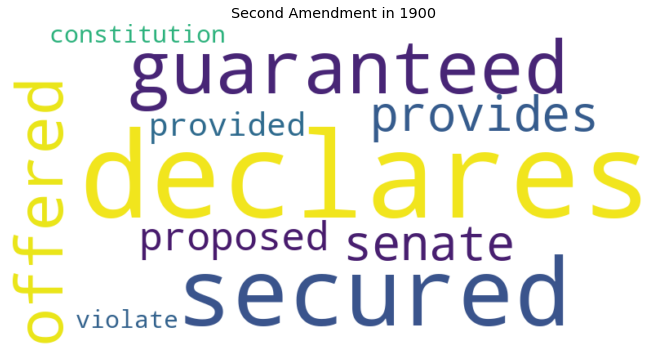

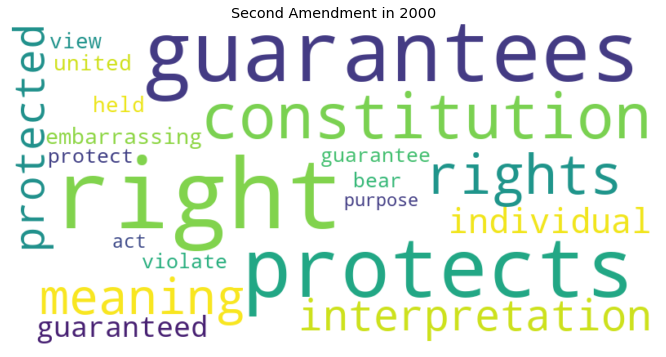

In [13]:
def draw_word_cloud(freq_dict):

    word_cloud = (WordCloud(width=800, height=400, stopwords=STOP_WORDS, max_words=20, background_color='white')
        .fit_words(freq_dict))
    
    plt.figure(figsize=(12, 6))
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
    
def plot_amendment_decade(amendment, decade):
    df_query = df[(df['query'] == amendment)]
    draw_word_cloud(df_query[df_query['decade'] == decade].set_index("w")['total'].to_dict())
    plt.title("{} in {}".format(amendment.title(), decade))
    
display(plot_amendment_decade(AMENDMENTS[2-1], 1900))
display(plot_amendment_decade(AMENDMENTS[2-1], 2000))